In [3]:
from qiskit import *
%matplotlib inline

In [2]:
nquibits = 3

circuit = QuantumCircuit(nquibits, nquibits)

circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)

circuit.measure([0, 1, 2], [0, 1, 2])

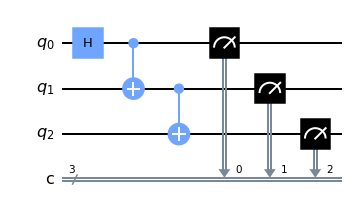

In [4]:
circuit.draw(output='mpl')

In [5]:
simulator = Aer.get_backend('qasm_simulator')

sim_result = execute(circuit, backend=simulator, shots=1024).result()

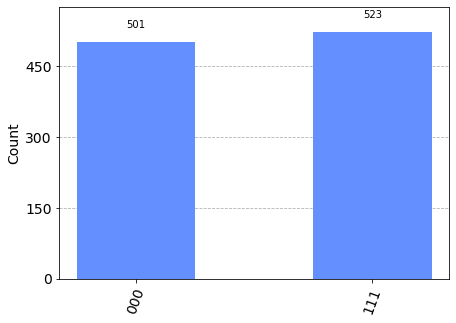

In [6]:
from qiskit.visualization import plot_histogram

plot_histogram(sim_result.get_counts(circuit))

## run on real Quantum Computer

In [8]:
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2022-10-17 23:47:19,204: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
job = execute(circuit, backend = device, shots = 1024)

print(job.job_id())

from qiskit.tools.monitor import job_monitor
job_monitor(job)

634d959065bf29f255a7596d
Job Status: job has successfully run


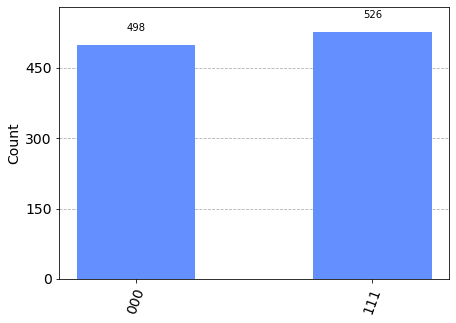

In [10]:
#getting result

device_result = job.result()

plot_histogram(device_result.get_counts(circuit))

### Mitigation of error if has any

In [12]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

C:\Users\User\AppData\Local\Temp\ipykernel_3592\1503385324.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)


In [14]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

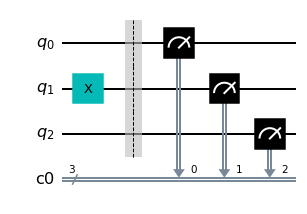

In [15]:
cal_circuits[2].draw(output='mpl')

In [16]:
len(cal_circuits)

8

In [17]:
cal_job = execute(cal_circuits,
                  backend=device,
                  shots=1024,
                  optimization_level=0
                 )

print(cal_job.job_id())

job_monitor(cal_job)
cal_results = cal_job.result()

634d98197d2071d5c2593db2
Job Status: job has successfully run


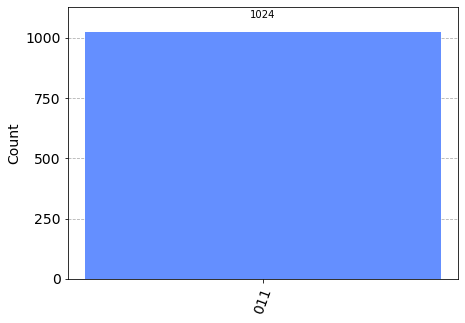

In [18]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

In [19]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

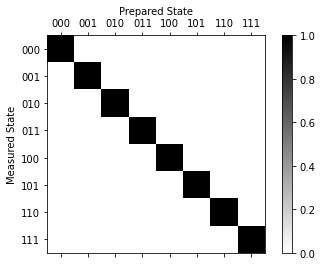

In [20]:
meas_fitter.plot_calibration()

In [21]:
meas_filter = meas_fitter.filter

In [22]:
mitigated_result = meas_filter.apply(device_result)

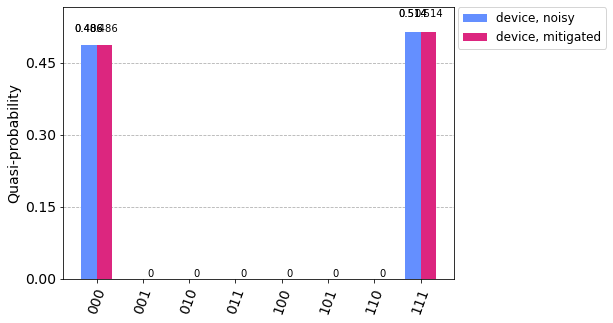

In [23]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)

plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

## Let's try this out for another circuit

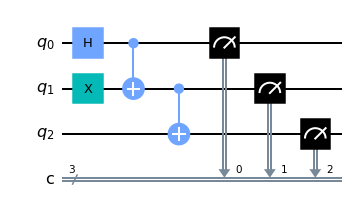

In [24]:
circuit1 = QuantumCircuit(3, 3)
circuit1.x(1)
circuit1.h(0)
circuit1.cx(0, 1)
circuit1.cx(1, 2)

circuit1.measure([0, 1, 2], [0, 1, 2])
circuit1.draw(output='mpl')

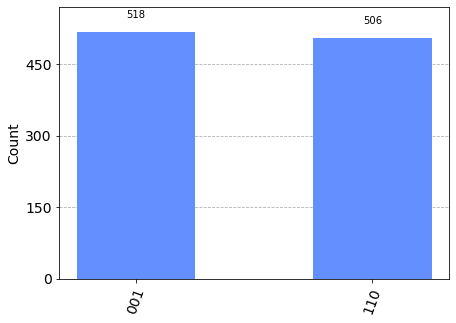

In [25]:
plot_histogram(
    execute(circuit1, backend=simulator, shots=1024).result().get_counts(circuit1)
)

In [26]:
device_count2 = execute(circuit1, backend=device, shots=1024).result().get_counts(circuit1)

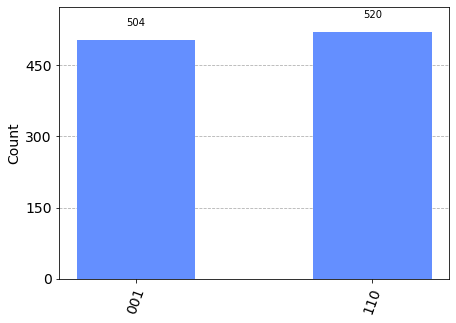

In [27]:
plot_histogram(device_count2)

In [28]:
#as measurement filter ready, we can just apply

device_mitigated_counts2 = meas_filter.apply(device_count2)

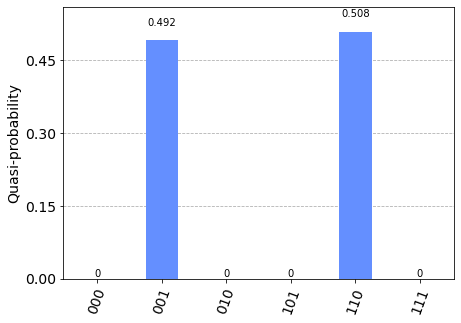

In [29]:
plot_histogram(device_mitigated_counts2)